In [1]:
import argparse
import torch
from data_provider_pretrain.data_factory import data_provider
from models.time_series_diffusion_model import TimeSeriesDiffusionModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from utils.callbacks import EMA
from lightning.pytorch.loggers import WandbLogger
import time
import random
import numpy as np
import os
import wandb
from datetime import timedelta
from utils.clean_args import clean_args
os.environ['CURL_CA_BUNDLE'] = ''
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

parser = argparse.ArgumentParser(description='Time-LLM')

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
torch.cuda.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class DotDict(dict):
    """
    A dictionary that supports both dot notation and dictionary access.
    This allows both `args.att` and `args['att']` to work.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __delattr__(self, item):
        self.__dict__.pop(item, None)

default_config = DotDict({
    # Basic config
    "num_nodes": 1,
    "task_name": "long_term_forecast",
    "is_training": 1,
    "model_id": "ETTh1_ETTh2_512_192",
    "model": "ns_Transformer",
    "precision": "32",
    
    # Data loader
    "data_pretrain": "Glucose",
    "root_path": "/home/yl2428/Time-LLM/dataset/glucose",
    "data_path": "combined_data_Jun_28.csv",
    "data_path_pretrain": "combined_data_Jun_28.csv",
    "features": "M",
    "target": "OT",
    "freq": "t",
    "checkpoints": "/gpfs/gibbs/pi/gerstein/yl2428/checkpoints/",
    "log_dir": "/gpfs/gibbs/pi/gerstein/yl2428/logs",
    
    # Forecasting task
    "seq_len": 128,
    "label_len": 12,
    "pred_len": 32,
    "seasonal_patterns": "Monthly",
    "stride": 8,
    
    # Model define
    "enc_in": 4,
    "dec_in": 4,
    "c_out": 4,
    "d_model": 32,
    "n_heads": 8,
    "e_layers": 2,
    "d_layers": 1,
    "d_ff": 128,
    "moving_avg": 25,
    "factor": 3,
    "dropout": 0.1,
    "embed": "timeF",
    "activation": "gelu",
    "output_attention": False,
    "patch_len": 16,
    "prompt_domain": 0,
    "llm_model": "LLAMA",
    "llm_dim": 4096,
    
    # Optimization
    "num_workers": 10,
    "itr": 1,
    "train_epochs": 100,
    "align_epochs": 10,
    "ema_decay": 0.97,
    "batch_size": 64,
    "eval_batch_size": 2,
    "patience": 10,
    "learning_rate": 0.0004,
    "des": "Exp",
    "loss": "MSE",
    "lradj": "COS",
    "pct_start": 0.2,
    "use_amp": False,
    "llm_layers": 32,
    "percent": 100,
    "num_individuals": -1,
    "enable_covariates": 1,
    "cov_type": "tensor",
    "gradient_accumulation_steps": 1,
    "use_deep_speed": 1,
    
    # Wandb
    "wandb": 1,
    "wandb_group": None,
    "wandb_api_key": "6f1080f993d5d7ad6103e69ef57dd9291f1bf366",
    "num_experts": 8,
    "head_dropout": 0.1,
    
    # TimeMixer-specific parameters
    "channel_independence": 0,
    "decomp_method": "moving_avg",
    "use_norm": 1,
    "down_sampling_layers": 2,
    "down_sampling_window": 1,
    "down_sampling_method": "avg",
    "use_future_temporal_feature": 0,
    
    # Diffusion specific parameters
    "k_z": 1e-2,
    "k_cond": 1,
    "d_z": 8,
    
    # De-stationary projector params
    "p_hidden_dims": [64, 64],
    "p_hidden_layers": 2,
    
    # CART related args
    "diffusion_config_dir": "/home/yl2428/Time-LLM/models/model9_NS_transformer/configs/toy_8gauss.yml",
    "cond_pred_model_pertrain_dir": None,
    "CART_input_x_embed_dim": 32,
    "mse_timestep": 0,
    "MLP_diffusion_net": False,
    
    # Ax args
    "timesteps": 1000,
    
    # Additional parameters
    "master_port": 8889,
    "comment": "TimeLLM-ECL"
})


args = default_config

for ii in range(args.itr):
    train_data, train_loader, args = data_provider(args, args.data_pretrain, args.data_path_pretrain, True, 'train')
    vali_data, vali_loader, args = data_provider(args, args.data_pretrain, args.data_path_pretrain, True, 'val')
    test_data, test_loader, args = data_provider(args, args.data_pretrain, args.data_path_pretrain, False, 'test')
    model = TimeSeriesDiffusionModel(args, train_loader, vali_loader, test_loader)

Mean: [7.93461185e+01 6.53019535e+00 1.44037396e-02 1.44911487e+02]
Std: [20.41707644 20.84327263  0.27630121 55.13396884]
Loading data into memory...


100%|██████████| 496/496 [00:09<00:00, 53.32it/s]


Mean: [7.93461185e+01 6.53019535e+00 1.44037396e-02 1.44911487e+02]
Std: [20.41707644 20.84327263  0.27630121 55.13396884]
Loading data into memory...


100%|██████████| 496/496 [00:08<00:00, 56.15it/s]


Mean: [7.93461185e+01 6.53019535e+00 1.44037396e-02 1.44911487e+02]
Std: [20.41707644 20.84327263  0.27630121 55.13396884]
Loading data into memory...


100%|██████████| 496/496 [00:09<00:00, 54.61it/s]


In [2]:

trainer = pl.Trainer(
    accelerator='cuda',
    devices=1,
    precision='64')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
import torch

In [5]:
state_dict = torch.load('/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/checkpoints_1.pt')
# turn into double
for key in state_dict.keys():
    state_dict[key] = state_dict[key].double()

In [6]:
model.state_dict

<bound method Module.state_dict of TimeSeriesDiffusionModel(
  (model): Model(
    (diffussion_model): ConditionalGuidedModel(
      (lin1): ConditionalLinear(
        (lin): Linear(in_features=8, out_features=128, bias=True)
        (embed): Embedding(1001, 128)
      )
      (lin2): ConditionalLinear(
        (lin): Linear(in_features=128, out_features=128, bias=True)
        (embed): Embedding(1001, 128)
      )
      (lin3): ConditionalLinear(
        (lin): Linear(in_features=128, out_features=128, bias=True)
        (embed): Embedding(1001, 128)
      )
      (lin4): Linear(in_features=128, out_features=4, bias=True)
    )
    (enc_embedding): DataEmbedding(
      (value_embedding): TokenEmbedding(
        (tokenConv): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
      )
      (position_embedding): PositionalEmbedding()
      (temporal_embedding): TimeFeatureEmbedding(
        (embed): Linear(in_features=5, out_features=32, bias=Fa

In [6]:
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['cond_pred_model_train.enc_embedding.value_embedding.tokenConv.weight', 'cond_pred_model_train.enc_embedding.temporal_embedding.embed.weight', 'cond_pred_model_train.dec_embedding.value_embedding.tokenConv.weight', 'cond_pred_model_train.dec_embedding.temporal_embedding.embed.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.query_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.query_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.attention.key_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.key_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.attention.value_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.value_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.attention.out_projection.weight', 'cond_pred_model_train.encoder.attn_layers.0.attention.out_projection.bias', 'cond_pred_model_train.encoder.attn_layers.0.conv1

In [7]:
next(iter(train_loader))[0][0]

tensor([[[ 6.0344e-01, -3.1330e-01, -5.2131e-02,  1.7247e+00],
         [-5.7768e-02,  4.7801e+00, -5.2131e-02,  1.7972e+00],
         [ 1.3626e+00,  5.9883e-01, -5.2131e-02,  1.8698e+00],
         ...,
         [-1.4756e-01, -3.1330e-01, -5.2131e-02,  1.5977e+00],
         [-2.4552e-01, -3.1330e-01, -5.2131e-02,  1.6521e+00],
         [-2.7817e-01, -3.1330e-01, -5.2131e-02,  1.6703e+00]],

        [[ 8.8915e-01, -3.1330e-01, -5.2131e-02,  1.2712e+00],
         [ 7.0140e-01, -3.1330e-01, -5.2131e-02,  1.1806e+00],
         [ 1.7896e-01, -3.1330e-01, -5.2131e-02,  1.0173e+00],
         ...,
         [-1.1435e+00, -3.1330e-01, -5.2131e-02, -4.1556e-01],
         [-1.1435e+00, -3.1330e-01, -5.2131e-02, -4.1556e-01],
         [-1.1026e+00, -3.1330e-01, -5.2131e-02, -4.1556e-01]],

        [[ 1.1993e+00, -3.1330e-01, -5.2131e-02,  1.5614e+00],
         [ 1.0116e+00, -3.1330e-01, -5.2131e-02,  1.6703e+00],
         [ 6.8507e-01, -3.1330e-01, -5.2131e-02,  1.7428e+00],
         ...,
         

In [9]:
train_loader

In [21]:
trainer.test(model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 10/2865 [08:09<38:49:04,  0.02it/s]
Testing: |          | 9/? [01:26<00:00,  0.10it/s]

In [19]:
model.sample_outputs[1].keys()

dict_keys(['pred', 'true', 'batch_x', 'batch_x_mark', 'batch_y_mark', 'batch_cov'])

In [20]:
model.sample_outputs[0]['batch_x'].shape

torch.Size([64, 128, 4])

In [8]:
torch.save(model.sample_outputs, '/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/sample_outputs_May11.pt')

In [9]:
model.sample_outputs = torch.load('/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/sample_outputs.pt')

In [11]:
from torch_frame import stype

In [30]:
batch = model.sample_outputs[0]['batch']
batch_x, batch_y, batch_x_mark, batch_y_mark = batch[0]
batch_cov = batch[1]
with torch.no_grad():
    new_batch_x = batch_x.clone()
    new_batch_x[53, :, 1] = batch_x[53, :, 1].min()
    model.eval()
    new_batch = [None, None]
    new_batch[0] = new_batch_x, batch_y, batch_x_mark, batch_y_mark
    new_batch[1] = batch_cov
    model.sample_step(new_batch, 0)

In [27]:
len(model.sample_outputs)

11

tensor([-1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9663e-09,
        -1.9663e-09, -1.9663e-09, -1.9663e-09, -1.9

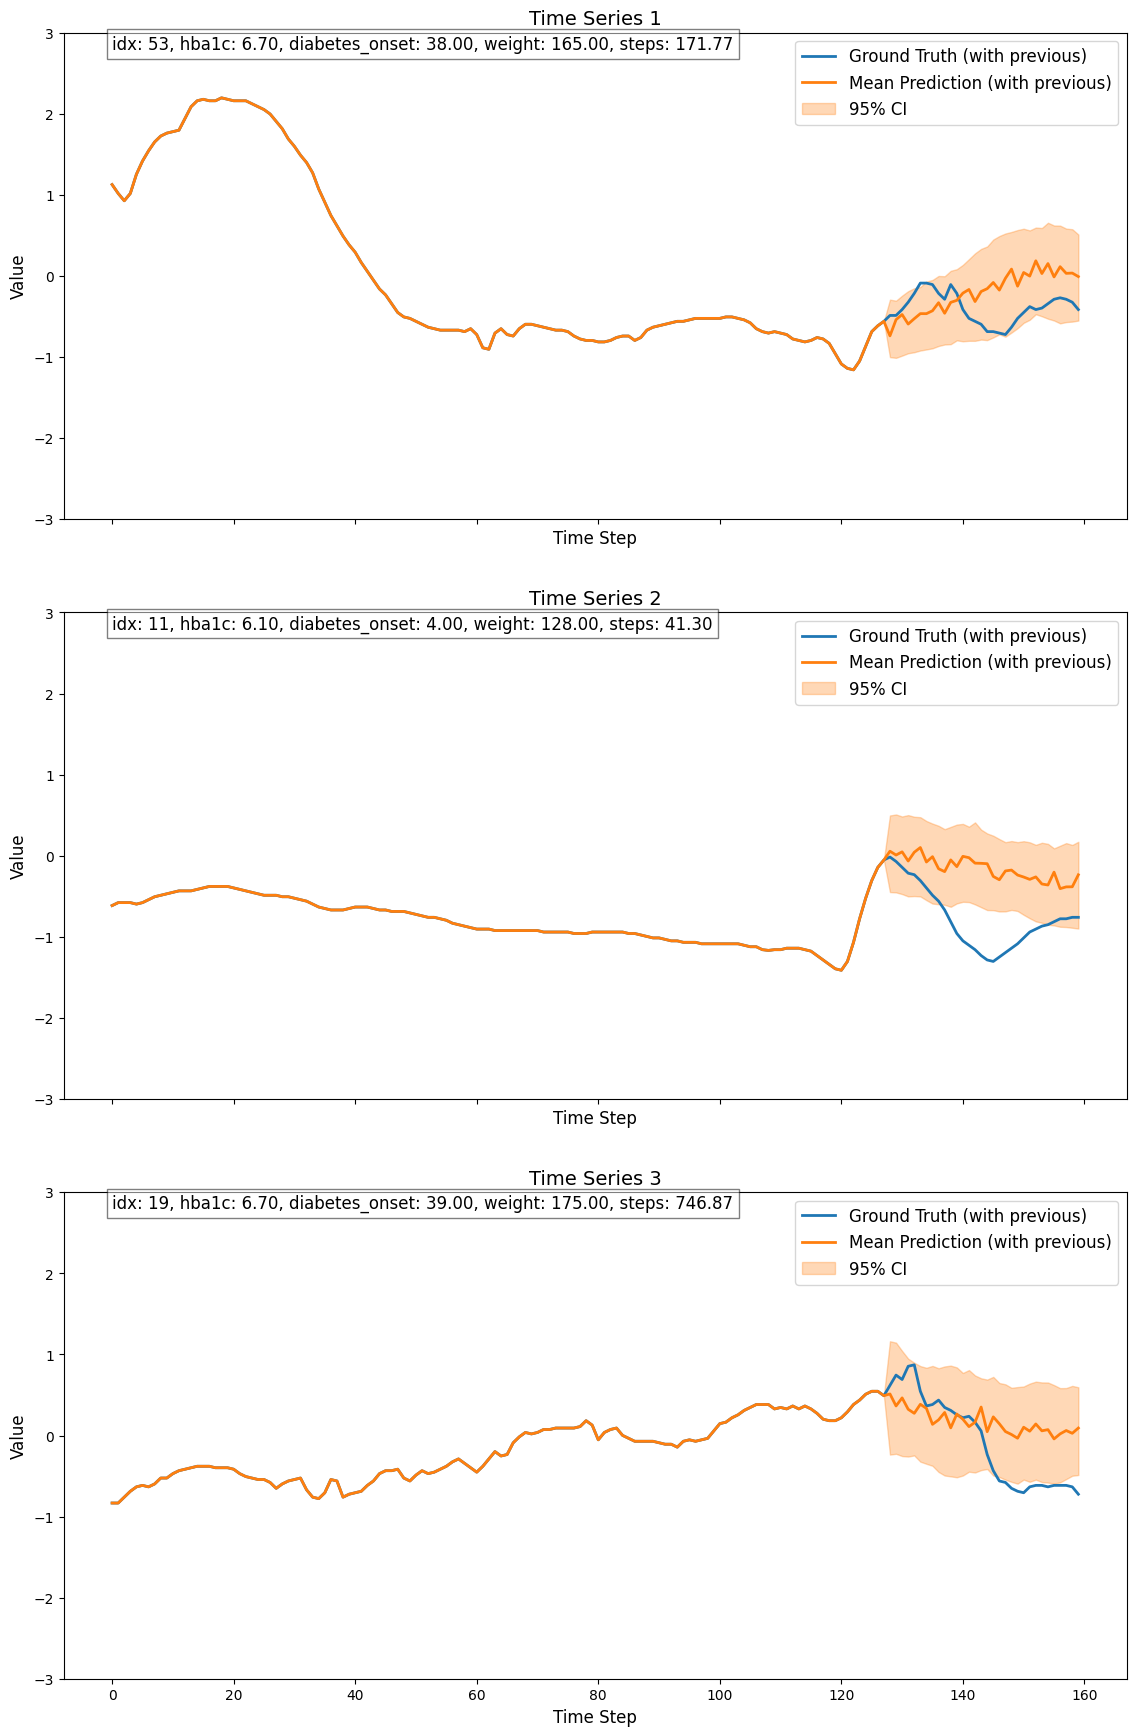

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.ndimage import uniform_filter1d
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def plot_time_series_with_ci(groundtruth, sampled_output, cov, batch_x=None, num_series=5):
    fig, axes = plt.subplots(num_series, 1, figsize=(12, 6*num_series), sharex=True)
    if num_series == 1:
        axes = [axes]
    idx_list = [53, 11, 19]  # Adjust or randomize this list as needed
    for i in range(num_series):
        # Randomly select a time series from the batch
        idx = idx_list[i]
        hba1c = cov.feat_dict[stype.numerical][idx, 3]
        diabetes_onset = cov.feat_dict[stype.numerical][idx, 1]
        weight = cov.feat_dict[stype.numerical][idx, 4]
        
        if batch_x is not None:
            # Extract previous glucose values
            previous_glucose = batch_x[idx, :, -1].cpu().numpy()
            hr = batch_x[idx, :, 0] * 20.41707644 + 7.93461185e+01
            steps = batch_x[idx, :, 1] * 20.84327263 +  6.53019535e+00
            print(steps)
            hr_mean = np.mean(hr.cpu().numpy())
            steps_mean = np.sum(steps.cpu().numpy())
            
            # Concatenate previous glucose with groundtruth and mean predictions
            full_groundtruth = np.concatenate([previous_glucose, groundtruth[idx, :, -1]])
        
        else:
            full_groundtruth = groundtruth[idx, :, -1].cpu().numpy()

        # Plot ground truth (concatenated)
        axes[i].plot(full_groundtruth, color='#1f77b4', label='Ground Truth (with previous)', lw=2)
        
        # Add textual information
        axes[i].text(0, 2.8, f'idx: {idx}, hba1c: {hba1c.cpu().numpy():.2f}, diabetes_onset: {diabetes_onset.cpu().numpy():.2f}, weight: {weight.cpu().numpy():.2f}, steps: {steps_mean:.2f}', 
                     fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
        
        # Calculate mean and confidence interval for predicted values
        mean = np.mean(sampled_output[idx, :, :, 0], axis=0)
        ci_lower = np.percentile(sampled_output[idx, :, :, 0], 80, axis=0)
        ci_upper = np.percentile(sampled_output[idx, :, :, 0], 20, axis=0)
        
        # Smooth the CI with a moving average
        ci_lower_smooth = uniform_filter1d(ci_lower, size=5)
        ci_upper_smooth = uniform_filter1d(ci_upper, size=5)
        
        # Concatenate previous glucose with predicted mean and CI
        full_mean = np.concatenate([previous_glucose, mean])
        full_ci_lower = np.concatenate([previous_glucose, ci_lower_smooth])
        full_ci_upper = np.concatenate([previous_glucose, ci_upper_smooth])
        
        # Plot mean prediction (concatenated)
        axes[i].plot(full_mean, color='#ff7f0e', label='Mean Prediction (with previous)', lw=2)
        
        # Plot confidence interval (concatenated)
        axes[i].fill_between(range(full_mean.shape[0]), full_ci_lower, full_ci_upper, color='#ff7f0e', alpha=0.3, label='95% CI')
        
        axes[i].set_title(f'Time Series {i+1}', fontsize=14)
        axes[i].set_xlabel('Time Step', fontsize=12)
        axes[i].set_ylabel('Value', fontsize=12)
        
        # Set y limit to be the same for all plots
        axes[i].set_ylim([-3, 3])
        axes[i].legend(loc='upper right', fontsize=12)
    
    plt.tight_layout(pad=3.0)
    plt.savefig('time_series_with_ci.pdf')
    plt.show()

# Sample invocation of the function with your data
# plot_time_series_with_ci(groundtruth, sampled_output, cov, num_series=5)

j = -1
groundtruth_to_plot = model.sample_outputs[j]['true']
sampled_output_to_plot = model.sample_outputs[j]['pred']
cov_to_plot = model.sample_outputs[j]['batch_cov']
batch_x_to_plot = model.sample_outputs[j]['batch_x']
# Call the function to plot 2 random time series
plot_time_series_with_ci(groundtruth_to_plot, sampled_output_to_plot, cov_to_plot, batch_x_to_plot, num_series=3)

In [ ]:
# Clone the specific slice you intend to modify
original_tensor_slice = batch_cov_orig.feat_dict[stype.numerical][:, 3]
modified_slice = original_tensor_slice.clone() * 1.1
batch_cov_orig.feat_dict[stype.numerical][:, 3] = modified_slice

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [ ]:
# Clone the specific slice you intend to modify
original_tensor_slice = batch_cov_orig.feat_dict[stype.numerical][:, 3]
modified_slice = original_tensor_slice.clone() * 1.1
batch_cov_orig.feat_dict[stype.numerical][:, 3] = modified_slice

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [ ]:
# Clone the specific slice you intend to modify
original_tensor_slice = batch_cov_orig.feat_dict[stype.numerical][:, 3]
modified_slice = original_tensor_slice.clone() * 1.1
batch_cov_orig.feat_dict[stype.numerical][:, 3] = modified_slice

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [ ]:
# Clone the specific slice you intend to modify
original_tensor_slice = batch_cov_orig.feat_dict[stype.numerical][:, 3]
modified_slice = original_tensor_slice.clone() * 1.1
batch_cov_orig.feat_dict[stype.numerical][:, 3] = modified_slice

RuntimeError: Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.

In [30]:
batch_x

tensor([[[ 1.2891,  5.0049, -0.0521,  0.6001],
         [ 1.6402,  4.5506, -0.0521,  0.4732],
         [ 1.4361,  5.2279, -0.0521,  0.2374],
         ...,
         [-1.0210, -0.3133, -0.0521, -1.1229],
         [-1.0373, -0.3133, -0.0521, -1.1592],
         [-0.8578, -0.3133, -0.0521, -1.1592]],

        [[ 1.5912, -0.3133, -0.0521, -0.5425],
         [ 0.8157, -0.3114, -0.0521, -0.2523],
         [ 0.4320, -0.3133, -0.0521, -0.1072],
         ...,
         [ 0.2524,  1.8000, -0.0521,  2.1237],
         [-0.0578, -0.3133, -0.0521,  1.8335],
         [ 0.4483, -0.3133, -0.0521,  1.5070]],

        [[ 0.0647, -0.3133, -0.0521,  4.6448],
         [ 0.0239, -0.3133, -0.0521,  4.6448],
         [ 0.3259,  1.0338, -0.0521,  4.6448],
         ...,
         [-1.4047, -0.3133, -0.0521, -0.1072],
         [-0.7843, -0.3133, -0.0521, -0.1616],
         [-1.3884, -0.3133, -0.0521, -0.2342]],

        ...,

        [[-0.2863, -0.3133, -0.0521,  2.8129],
         [-0.3598, -0.3133, -0.0521,  2.8129]

In [29]:
import torch
import numpy as np
import random
from torch_frame import stype # Ensure this is consistent with how stype is used/imported earlier

# Ensure 'model' is loaded and model.sample_outputs is populated from previous cells.
# For example, if needed:
# model.sample_outputs = torch.load('/gpfs/gibbs/pi/gerstein/yl2428/logs/ns_Transformer/desert-sweep-6/checkpoints/sample_outputs.pt')

def perturb_hba1c_covariates(batch_cov, individual_indices, percentage_increase):
    """
    Perturbs HBA1c for specified individuals in the batch_cov.
    HBA1c is assumed to be at index 3 of the numerical features based on notebook analysis.
    Input batch_cov is expected to be a torch_frame.MaterializedFrame object or similar.
    Returns a new batch_cov object with perturbations; does not modify the input object.
    """
    if stype.numerical not in batch_cov.feat_dict:
        print(f"Warning: stype.numerical ('{stype.numerical}') not found in batch_cov.feat_dict. Returning original batch_cov.")
        return batch_cov

    # Clone the numerical features tensor to ensure modifications do not affect the original batch_cov
    original_numerical_tensor = batch_cov.feat_dict[stype.numerical]
    perturbed_numerical_tensor = original_numerical_tensor.clone()
    
    for idx in individual_indices:
        if 0 <= idx < perturbed_numerical_tensor.shape[0]:
            # Modify the cloned tensor
            current_hba1c_val = perturbed_numerical_tensor[idx, 3]
            perturbed_numerical_tensor[idx, 3] = current_hba1c_val * (1 + percentage_increase / 100.0)
            # print(f"Individual {idx}: HbA1c changed from {current_hba1c_val.item():.2f} to {perturbed_numerical_tensor[idx, 3].item():.2f}")
        else:
            print(f"Warning: Index {idx} is out of bounds for numerical_feats (shape: {perturbed_numerical_tensor.shape}). Skipping perturbation for this index.")
            
    from copy import deepcopy
    new_feat_dict = deepcopy(batch_cov) 
    # 
    new_feat_dict.feat_dict[stype.numerical] = perturbed_numerical_tensor
    
    # Prepare arguments for constructing the new frame object.
    # It's important to pass all necessary attributes from the original batch_cov
    # that are required by its constructor (e.g., col_names_dict, col_stats).
    
    return new_feat_dict

def perturb_steps_batch_x(original_data_tuple, individual_indices, percentage_increase):
    """
    Perturbs 'steps' for specified individuals in batch_x.
    'steps' are derived from batch_x[:, :, STEPS_FEATURE_INDEX_IN_BATCH_X] using a specific formula.
    This function assumes batch_x is the first element of original_data_tuple:
    original_data_tuple = (batch_x, batch_y, batch_x_mark, batch_y_mark)
    Returns a new data_tuple with batch_x perturbed; does not modify the input tuple or its tensors.
    """
    # Constants for step calculation, as provided
    STEPS_SCALE = 20.84327263
    STEPS_OFFSET = 6.53019535e+00
    STEPS_FEATURE_INDEX_IN_BATCH_X = 1 # 0-indexed

    if not (isinstance(original_data_tuple, tuple) and len(original_data_tuple) > 0 and hasattr(original_data_tuple[0], 'clone')):
        print("Warning: original_data_tuple is not in the expected format (tuple with a clonable tensor as first element). Returning original tuple.")
        return original_data_tuple

    original_batch_x = original_data_tuple[0]
    perturbed_batch_x = original_batch_x.clone() # Ensure we don't modify the original tensor

    for idx in individual_indices:
        if 0 <= idx < perturbed_batch_x.shape[0]:
            # Extract the scaled feature series for steps for the specific individual
            scaled_steps_series = perturbed_batch_x[idx, :, STEPS_FEATURE_INDEX_IN_BATCH_X]

            # Calculate current "true" step values (element-wise for the series)
            current_true_steps = scaled_steps_series * STEPS_SCALE + STEPS_OFFSET

            # Perturb the "true" step values
            perturbed_true_steps = current_true_steps * (1 + percentage_increase / 100.0)

            # Convert perturbed "true" steps back to scaled values for storage in batch_x
            new_scaled_steps_series = (perturbed_true_steps - STEPS_OFFSET) / STEPS_SCALE

            # Update the cloned batch_x with the new scaled step series
            perturbed_batch_x[idx, :, STEPS_FEATURE_INDEX_IN_BATCH_X] = new_scaled_steps_series
        else:
            print(f"Warning: Index {idx} for perturbation is out of bounds for batch_x (shape: {perturbed_batch_x.shape[0]}). Skipping perturbation for this index.")

    # Reconstruct the data tuple with the perturbed batch_x
    new_data_list = list(original_data_tuple)
    new_data_list[0] = perturbed_batch_x
    new_data_tuple = tuple(new_data_list)
    
    return new_data_tuple

In [48]:
# --- Perturbation Analysis ---
# Select a batch for analysis (e.g., the last one processed or a specific one)
# If model.sample_outputs is a list of outputs from trainer.test:
# Each element in model.sample_outputs would typically be a dictionary
# from a single batch processed by test_step.
# We'll use the last batch's data as an example.
# You might need to adjust which batch or how data is selected based on your exact structure.

if not model.sample_outputs:
    print("Error: model.sample_outputs is empty. Please ensure the model has processed data and populated this list.")
else:
    # Assuming the structure seen in the notebook: model.sample_outputs[i]['batch']
    # and model.sample_outputs[i]['pred'] for predictions.
    # We need an original batch to get 'batch_x', 'batch_y', 'batch_x_mark', 'batch_y_mark', and 'batch_cov'.
    
    # Let's use the data from the last entry in sample_outputs for perturbation
    # This corresponds to the data used for the last plot in the notebook (j = -1)
    # Or you can select a specific batch index, e.g., batch_index_to_perturb = 0
    batch_index_to_perturb = -1 # Use the last batch by default
    
    original_batch_data_dict = model.sample_outputs[batch_index_to_perturb]
    original_batch_tuple = original_batch_data_dict['batch'] # This is [ (batch_x, batch_y, batch_x_mark, batch_y_mark), batch_cov ]
    
    batch_x_orig, batch_y_orig, batch_x_mark_orig, batch_y_mark_orig = original_batch_tuple[0]
    batch_cov_orig = original_batch_tuple[1]

    # Get original predictions (samples before perturbation)
    # These are the 'pred' values from the model's output for this original batch
    # Assuming 'pred' stores the 50 samples: [batch_size, num_samples, pred_len, num_features]
    # And we are interested in the glucose feature, which is the last one (index -1 or 3 for c_out=4)
    sampled_output_before_perturb = original_batch_data_dict['pred'][..., -1] # Taking only glucose

    num_individuals_in_batch = batch_x_orig.shape[0]
    num_to_perturb = min(10, num_individuals_in_batch) # Perturb up to 3 individuals, or fewer if batch is small

    # Randomly select individuals to perturb
    # Ensure reproducibility if desired, by setting random.seed elsewhere or here for this specific selection
    # random.seed(42) # for reproducibility of selection
    individuals_to_perturb_indices = random.sample(range(num_individuals_in_batch), num_to_perturb)
    print(f"Original batch size: {num_individuals_in_batch}")
    print(f"Randomly selected individuals to perturb (indices): {individuals_to_perturb_indices}")

    # Perturb HBA1c for the selected individuals
    percentage_increase_hba1c = 200.0
    batch_cov_perturbed = perturb_hba1c_covariates(batch_cov_orig, individuals_to_perturb_indices, percentage_increase_hba1c)

    # Prepare the new batch for the model's sample_step or equivalent generation function
    # The model.sample_step(batch, batch_idx) was used in the notebook
    # We need to simulate how samples are generated or find the appropriate generation function.
    # If model.sample_step appends to model.sample_outputs, we need to handle that.
    # For now, let's assume we need to call a generation function.
    # The `sample_step` in TimeSeriesDiffusionModel takes `batch` and `batch_idx`
    # and seems to append to `self.sample_outputs`.
    # To get samples for the perturbed data without altering `model.sample_outputs` from original runs,
    # we might need to call a more direct sampling/prediction method of the model if available,
    # or temporarily store and then restore `model.sample_outputs`.

    # Let's try to get new samples.
    # The model's `predict_step` or a similar generation function is needed.
    # In TimeSeriesDiffusionModel, `sample_step` is used during `test_step` and it appends to `self.sample_outputs`.
    # A more direct way to get samples would be to call `model.model.sample()` (for the inner diffusion model)
    # or `model.cond_pred_model.predict()` if it's about conditional prediction.
    # Given the existing notebook structure, `model.sample_step` is what was used to generate `model.sample_outputs`.

    # To avoid confusion with previously stored sample_outputs, we will call a direct sampling method
    # of the underlying diffusion model if possible.
    # The TimeSeriesDiffusionModel has a `sample` method.
    # Signature: sample(self, batch_x, batch_x_mark, batch_y_mark, N=50, cond_scale=0.)
    
    # We need to get cond from batch_cov_perturbed
    # The model has `self.cond_pred_model.encode_cond(batch_cov)`
    # And then uses this `cond` in its own `sample` method, which calls `self.model.sample`.
    
    model.eval() # Ensure model is in eval mode
    with torch.no_grad():
        # 1. Encode covariates to get the condition
        # The `encode_cond` method might need the batch_cov on the correct device
        device = batch_x_orig.device # Assuming batch_x_orig is already on the correct device
        
        # The covariates in batch_cov_perturbed need to be on the same device as the model
        # Typically, the data loader handles this. Here we do it manually if needed.
        # Assuming batch_cov_perturbed.feat_dict[stype.numerical] is a tensor.
        
        # Create a new batch structure for the perturbed data
        perturbed_batch_for_sampling = [
            (batch_x_orig.to(device), batch_y_orig.to(device), batch_x_mark_orig.to(device), batch_y_mark_orig.to(device)), # Original x, y, x_mark, y_mark
            batch_cov_perturbed # Perturbed covariates
        ]

        model.sample_step(perturbed_batch_for_sampling , 0)
    
    sampled_output_after_perturb = model.sample_outputs[-1]['pred']

    print(f"Shape of original sampled output (glucose only): {sampled_output_before_perturb.shape}")
    print(f"Shape of perturbed sampled output (glucose only): {sampled_output_after_perturb.shape}")

    # Store HBA1c values for individuals of interest for plotting/stats
    original_hba1c_values = {}
    perturbed_hba1c_values = {}

    for i_idx in individuals_to_perturb_indices:
        original_hba1c_values[i_idx] = batch_cov_orig.feat_dict[stype.numerical][i_idx, 3].item()
        perturbed_hba1c_values[i_idx] = batch_cov_perturbed.feat_dict[stype.numerical][i_idx, 3].item()
        print(f"Individual {i_idx}: Original HbA1c: {original_hba1c_values[i_idx]:.2f}, Perturbed HbA1c: {perturbed_hba1c_values[i_idx]:.2f}")

# Ground truth for plotting (from the original selected batch)
groundtruth_for_plot = original_batch_data_dict['true'][..., -1]
batch_x_for_plot = original_batch_data_dict['batch_x'][..., -1]
sampled_output_after_perturb = model.sample_outputs[-1]['pred']

Original batch size: 64
Randomly selected individuals to perturb (indices): [50, 44, 7, 14, 15, 29, 28, 30, 61, 41]
Shape of original sampled output (glucose only): (64, 100, 32)
Shape of perturbed sampled output (glucose only): (64, 100, 32, 1)
Individual 50: Original HbA1c: 8.65, Perturbed HbA1c: 25.95
Individual 44: Original HbA1c: 8.12, Perturbed HbA1c: 24.36
Individual 7: Original HbA1c: 7.85, Perturbed HbA1c: 23.56
Individual 14: Original HbA1c: 16.24, Perturbed HbA1c: 48.71
Individual 15: Original HbA1c: 8.39, Perturbed HbA1c: 25.16
Individual 29: Original HbA1c: 8.52, Perturbed HbA1c: 25.56
Individual 28: Original HbA1c: 7.85, Perturbed HbA1c: 23.56
Individual 30: Original HbA1c: 7.85, Perturbed HbA1c: 23.56
Individual 61: Original HbA1c: 17.30, Perturbed HbA1c: 51.91
Individual 41: Original HbA1c: 11.31, Perturbed HbA1c: 33.94


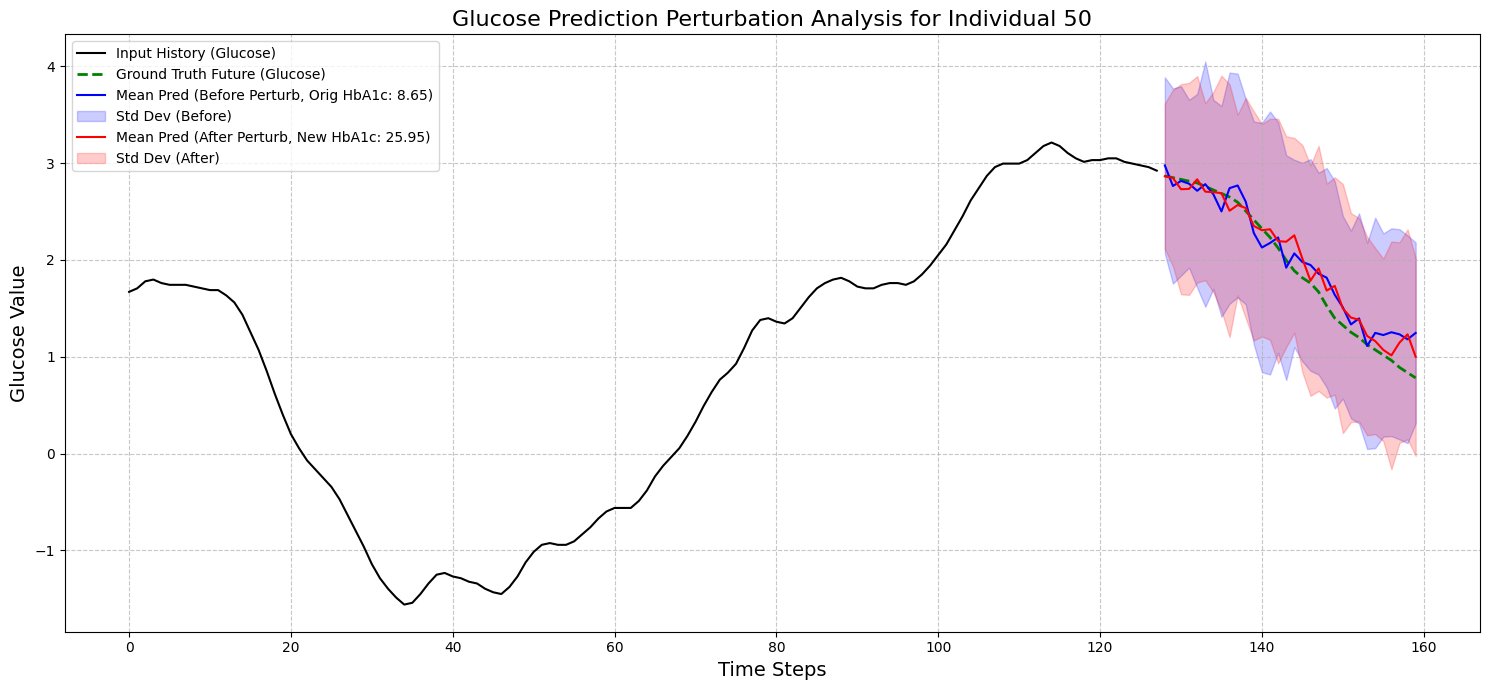

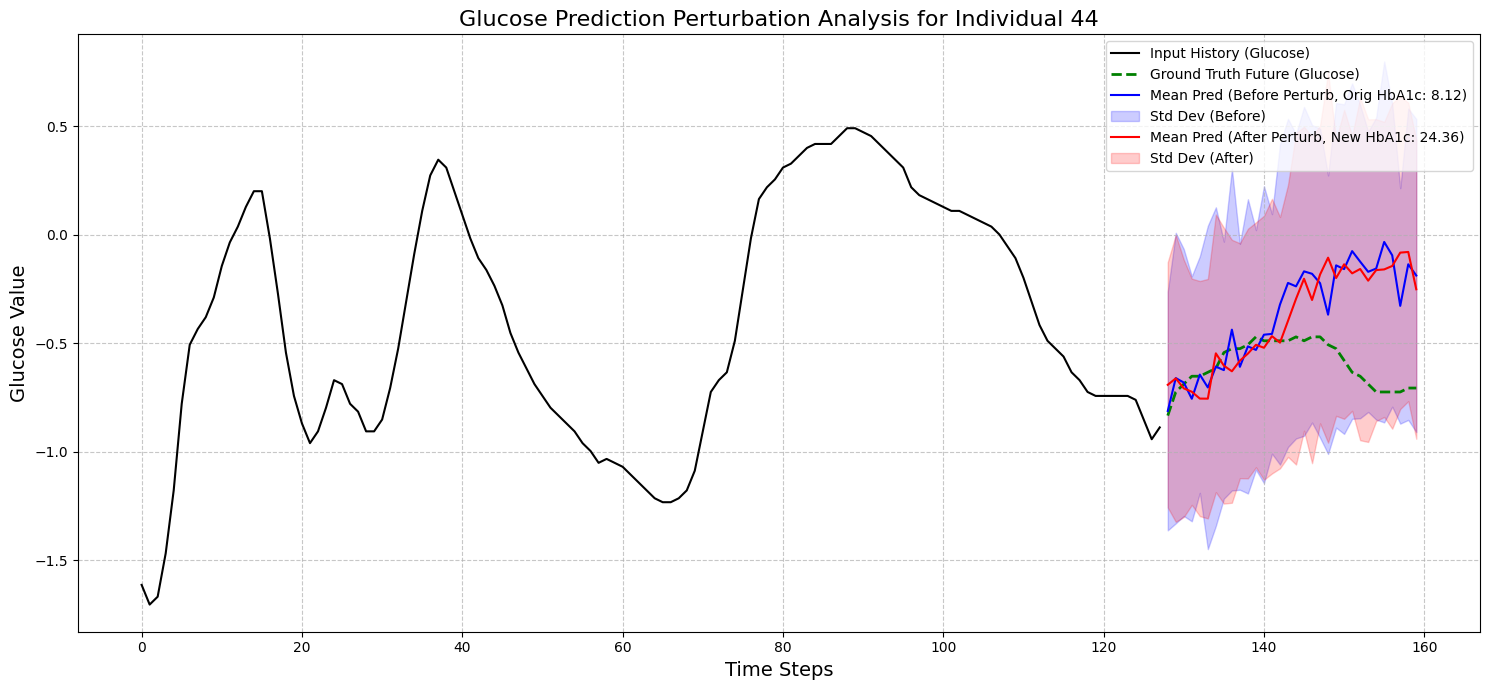

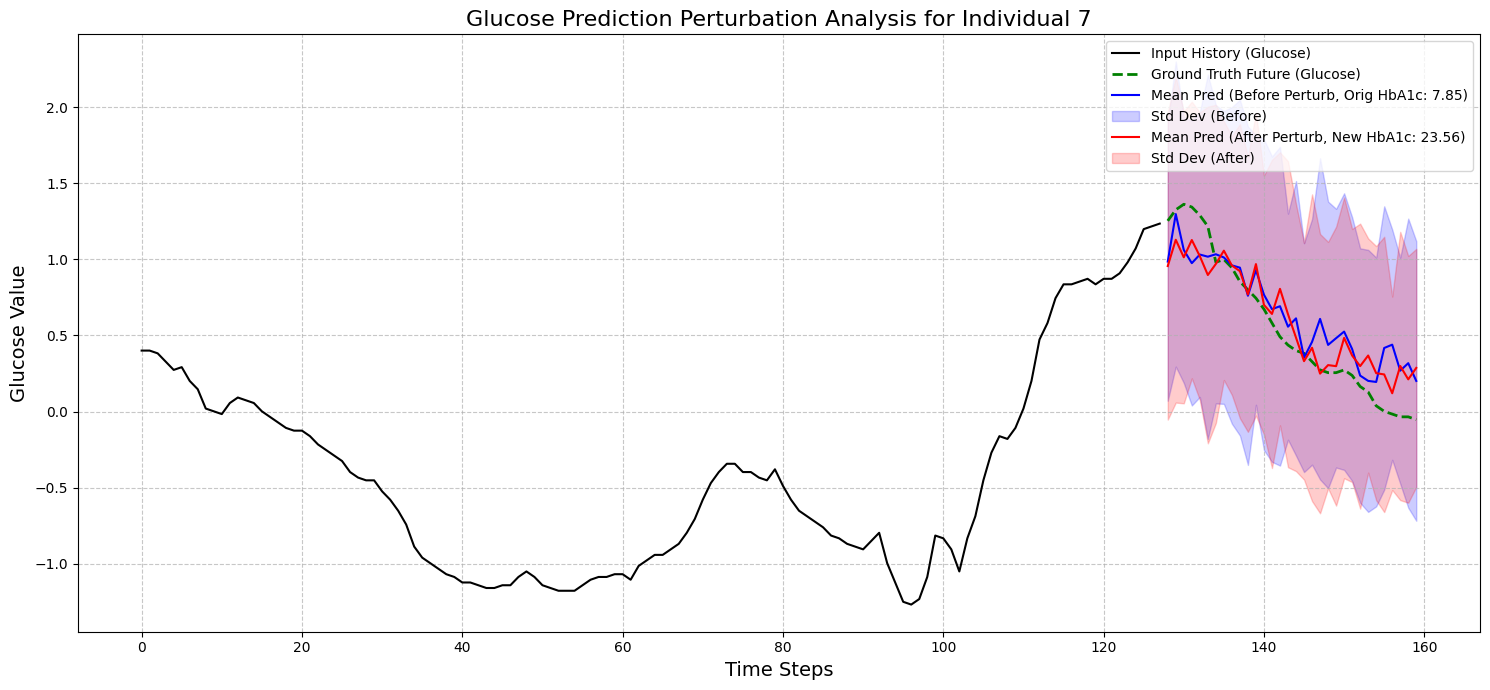

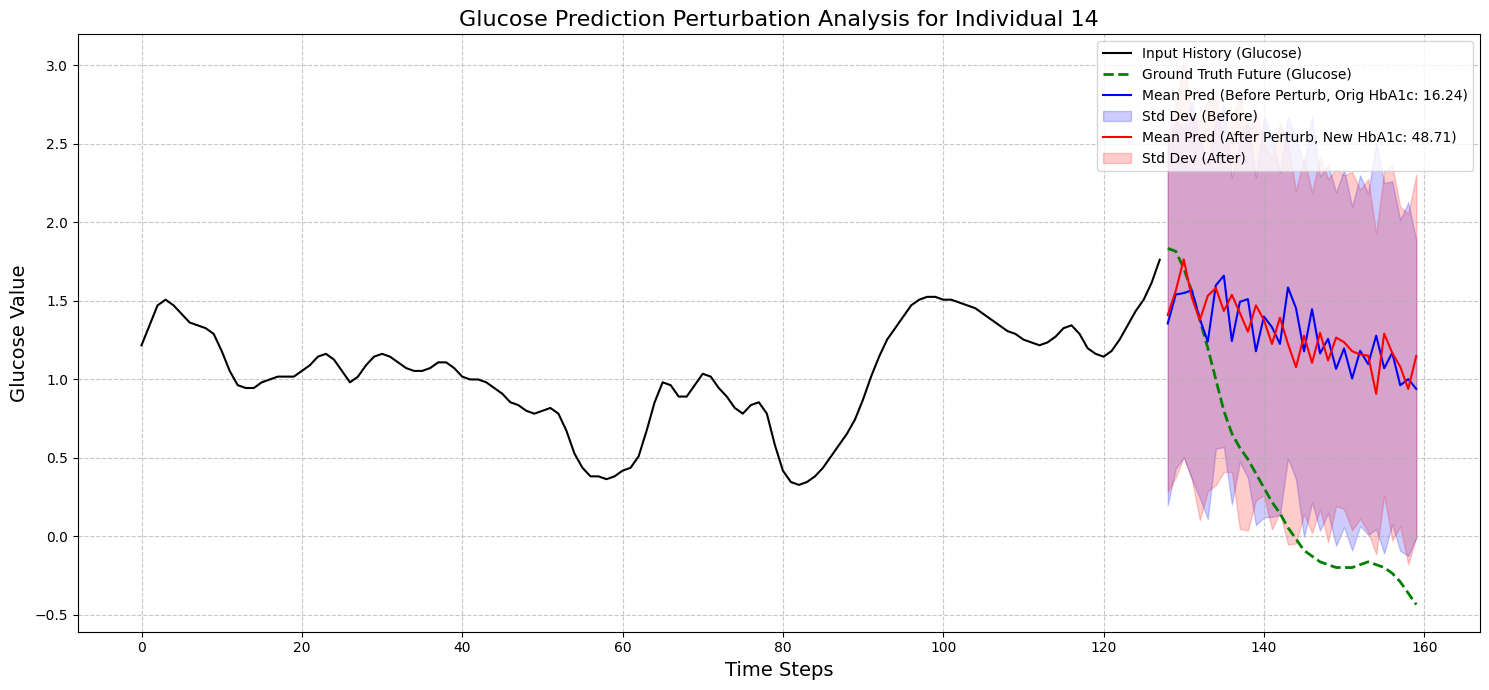

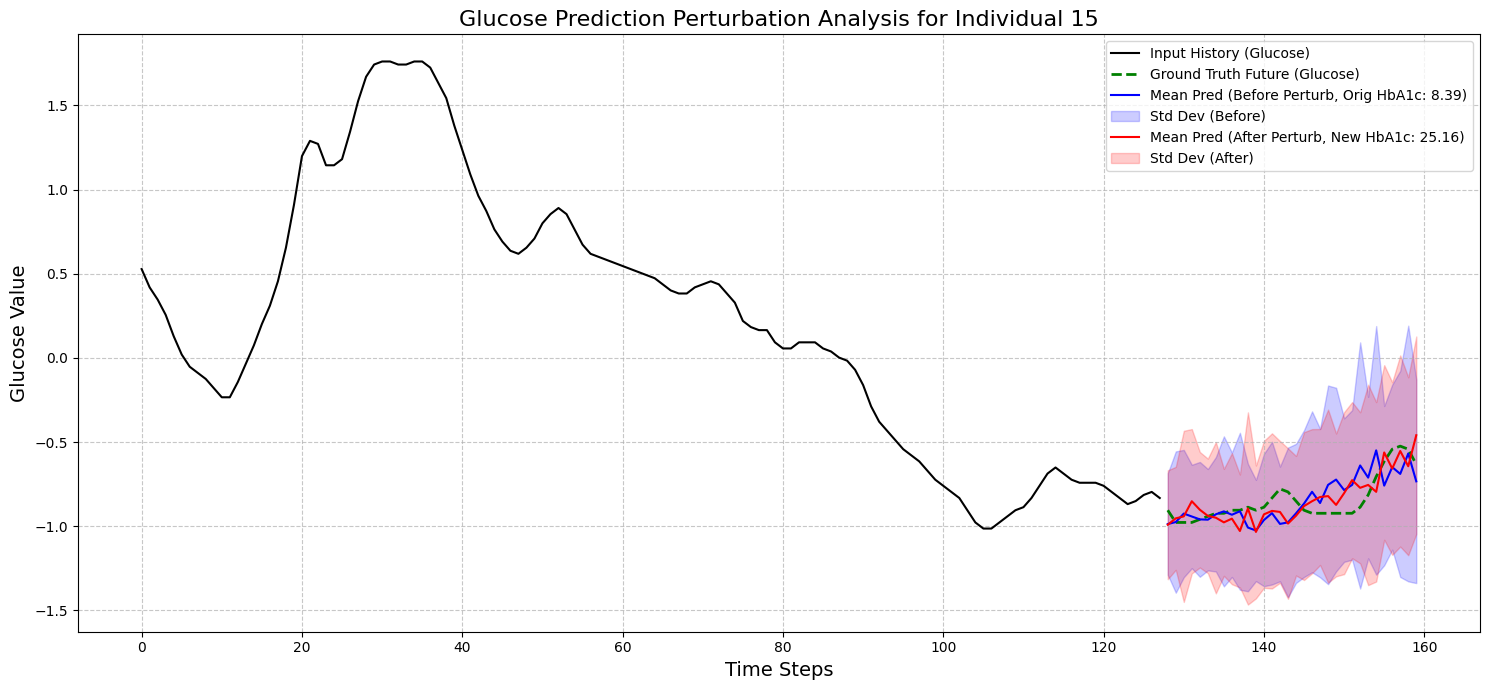

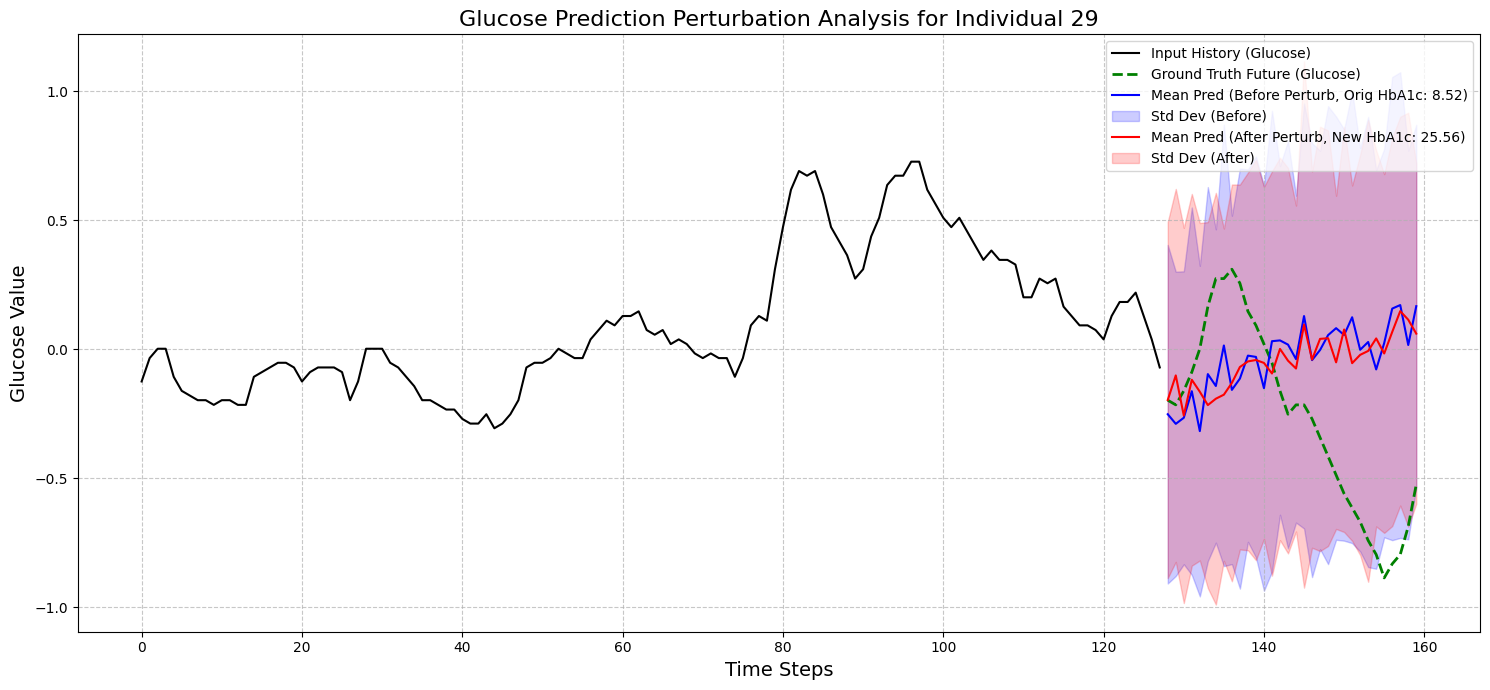

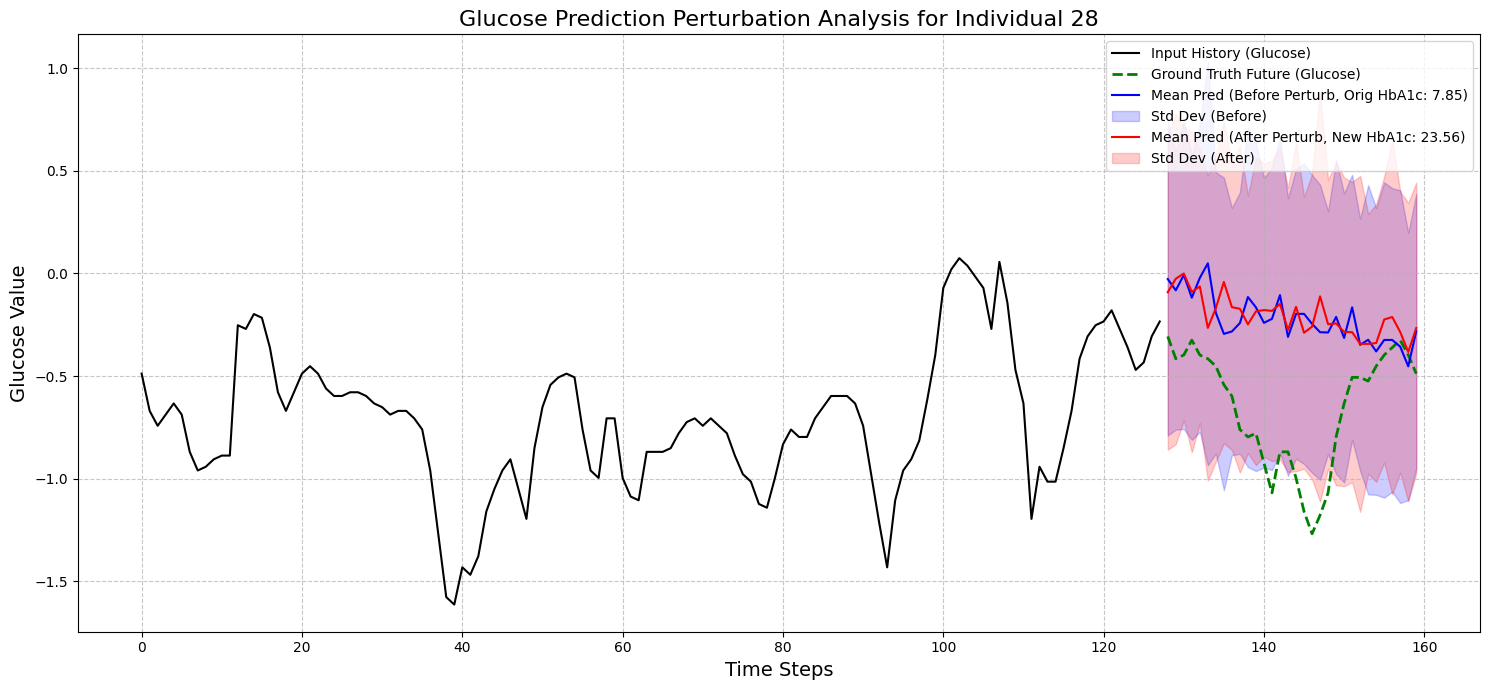

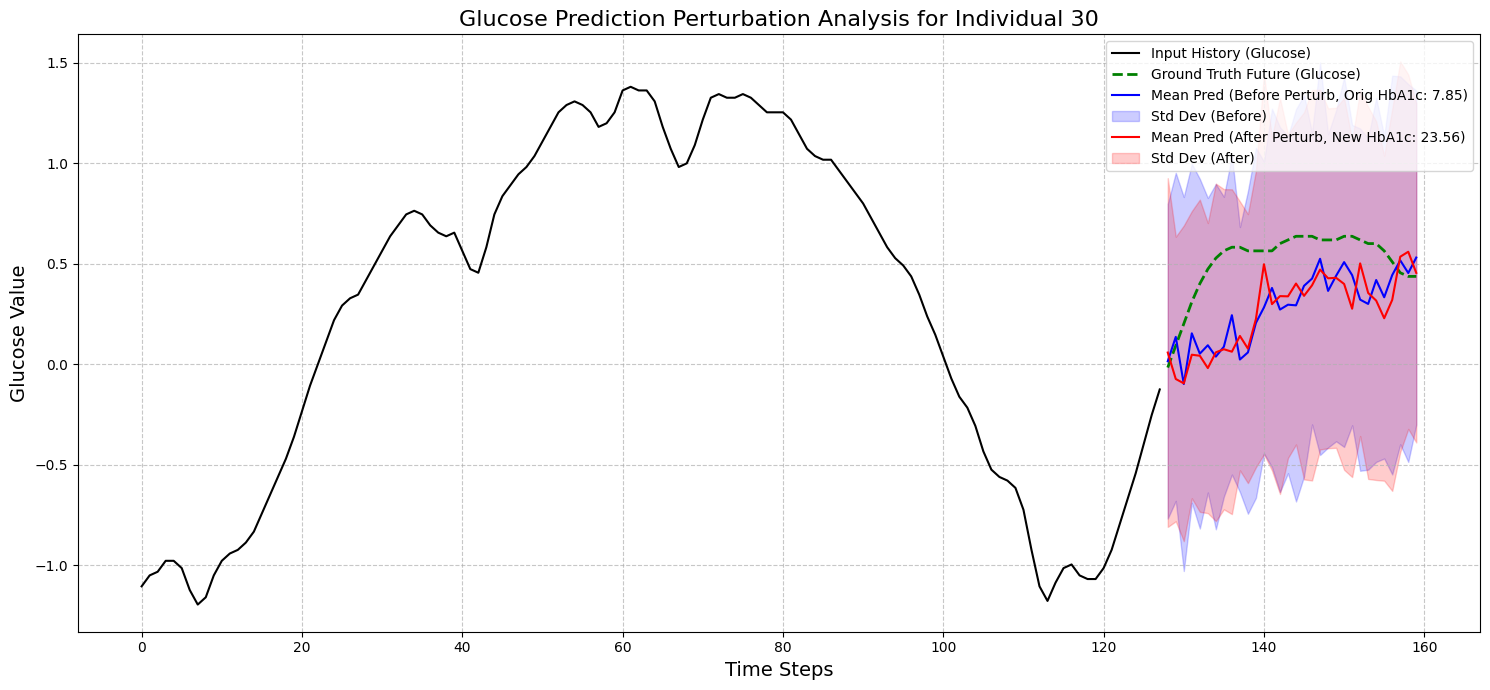

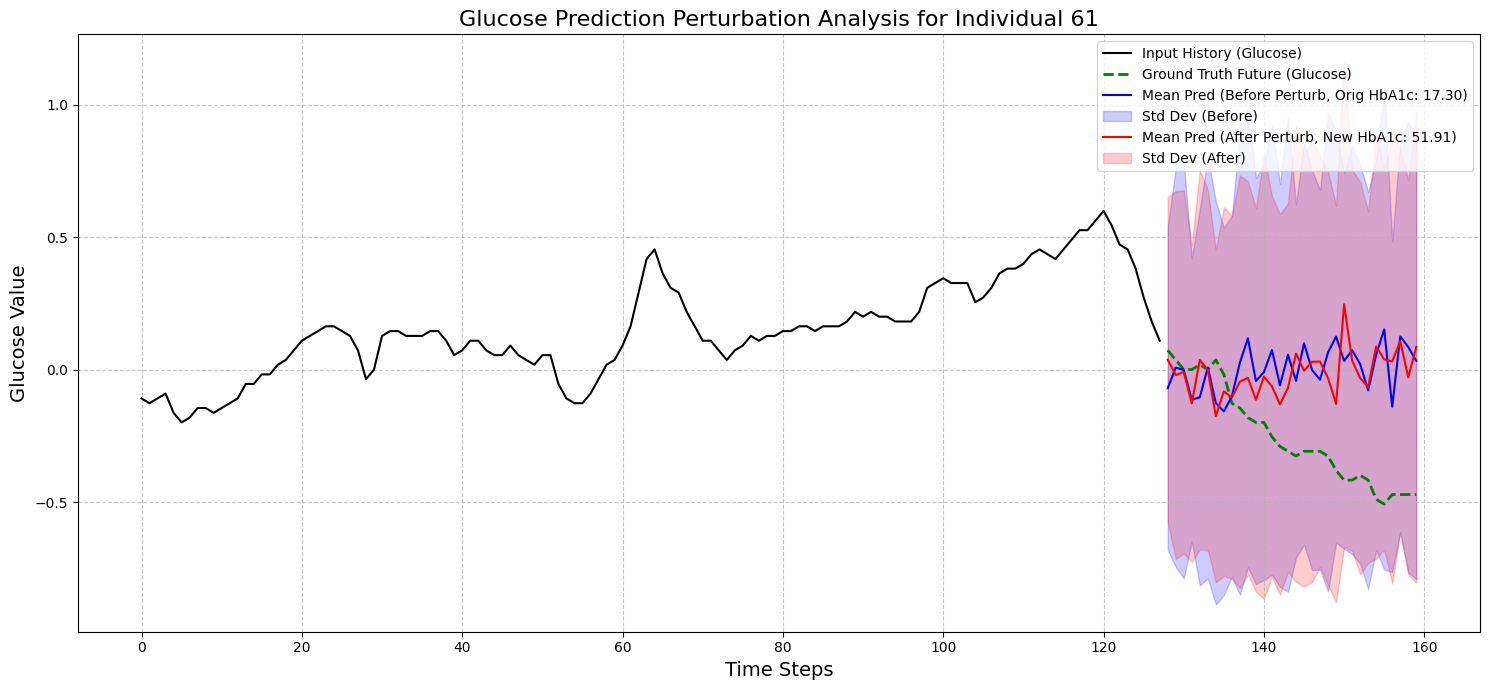

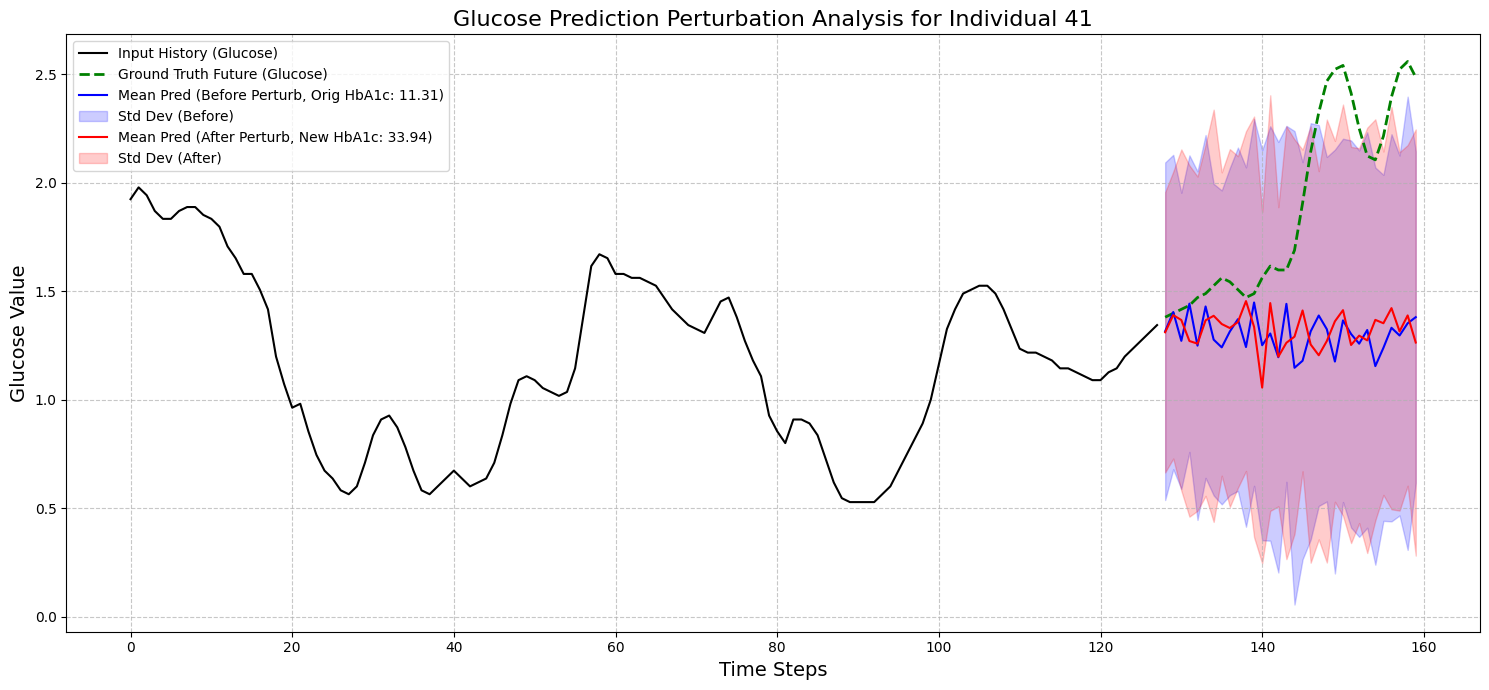

In [49]:
import matplotlib.pyplot as plt
import numpy as np

if not model.sample_outputs or 'individuals_to_perturb_indices' not in locals():
    print("Error: Ensure the perturbation analysis cell has been run and required variables are available.")
else:
    # Assuming c_out was 1 or f_dim correctly selected the single glucose feature for pred_len output
    # sampled_output_before_perturb shape: (batch_size, num_samples, pred_len)
    # sampled_output_after_perturb shape: (batch_size, num_samples, pred_len, 1) from notebook output
    # groundtruth_for_plot shape: (batch_size, pred_len)
    # batch_x_for_plot shape: (batch_size, seq_len)
    
    seq_len = batch_x_for_plot.shape[1]
    pred_len = groundtruth_for_plot.shape[1]
    time_history = np.arange(seq_len)
    time_pred = np.arange(seq_len, seq_len + pred_len)
    
    for idx in individuals_to_perturb_indices:
        history_data = batch_x_for_plot[idx].cpu().numpy()
        true_future_data = groundtruth_for_plot[idx]
        
        # Predictions before perturbation
        preds_before_raw = sampled_output_before_perturb[idx] # (num_samples, pred_len)
        mean_preds_before = np.mean(preds_before_raw, axis=0)
        std_preds_before = np.std(preds_before_raw, axis=0)
        
        # Predictions after perturbation
        # sampled_output_after_perturb has shape (batch_size, num_samples, pred_len, 1)
        preds_after_raw = sampled_output_after_perturb[idx, ..., 0] # (num_samples, pred_len)
        mean_preds_after = np.mean(preds_after_raw, axis=0)
        std_preds_after = np.std(preds_after_raw, axis=0)
        
        plt.figure(figsize=(15, 7))
        
        # Plot history
        plt.plot(time_history, history_data, label='Input History (Glucose)', color='black', linewidth=1.5)
        
        # Plot true future
        plt.plot(time_pred, true_future_data, label='Ground Truth Future (Glucose)', color='green', linestyle='--', linewidth=2)
        
        # Plot predictions before perturbation
        plt.plot(time_pred, mean_preds_before, 
                 label=f'Mean Pred (Before Perturb, Orig HbA1c: {original_hba1c_values[idx]:.2f})', 
                 color='blue', linewidth=1.5)
        plt.fill_between(time_pred, mean_preds_before - std_preds_before, mean_preds_before + std_preds_before, 
                         color='blue', alpha=0.2, label='Std Dev (Before)')
        
        # Plot predictions after perturbation
        plt.plot(time_pred, mean_preds_after, 
                 label=f'Mean Pred (After Perturb, New HbA1c: {perturbed_hba1c_values[idx]:.2f})', 
                 color='red', linewidth=1.5)
        plt.fill_between(time_pred, mean_preds_after - std_preds_after, mean_preds_after + std_preds_after, 
                         color='red', alpha=0.2, label='Std Dev (After)')
        
        plt.title(f'Glucose Prediction Perturbation Analysis for Individual {idx}', fontsize=16)
        plt.xlabel('Time Steps', fontsize=14)
        plt.ylabel('Glucose Value', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

In [50]:
import numpy as np

if 'individuals_to_perturb_indices' not in locals() or \
   'sampled_output_before_perturb' not in locals() or \
   'sampled_output_after_perturb' not in locals():
    print("Error: Ensure the perturbation analysis and plotting cells have been run, and variables are available.")
else:
    print("\n--- Comparison of Average Standard Deviations (Time-Averaged) ---\n")
    avg_std_devs_before_list = []
    avg_std_devs_after_list = []

    for idx in individuals_to_perturb_indices:
        # Predictions before perturbation: shape (num_samples, pred_len)"
        preds_before_raw = sampled_output_before_perturb[idx]
        # Std dev across samples for each time step: shape (pred_len,)"
        std_dev_over_samples_before = np.std(preds_before_raw, axis=0)
        # Average this std dev over the prediction length"
        avg_std_before = np.mean(std_dev_over_samples_before)
        avg_std_devs_before_list.append(avg_std_before)

        # Predictions after perturbation: shape (num_samples, pred_len) after [..., 0] slicing"
        preds_after_raw = sampled_output_after_perturb[idx, ..., 0]
        # Std dev across samples for each time step: shape (pred_len,)"
        std_dev_over_samples_after = np.std(preds_after_raw, axis=0)
        # Average this std dev over the prediction length"
        avg_std_after = np.mean(std_dev_over_samples_after)
        avg_std_devs_after_list.append(avg_std_after)

        print(f"Individual {idx}:")
        print(f"  Avg. Std. Dev (Before Perturbation): {avg_std_before:.4f}")
        print(f"  Avg. Std. Dev (After Perturbation):  {avg_std_after:.4f}")
        if avg_std_after > avg_std_before:
            print(f"  Comparison: Uncertainty (std dev) INCREASED by {avg_std_after - avg_std_before:.4f} after perturbation.")
        elif avg_std_after < avg_std_before:
            print(f"  Comparison: Uncertainty (std dev) DECREASED by {avg_std_before - avg_std_after:.4f} after perturbation.")
        else:
            print(f"  Comparison: Uncertainty (std dev) remained the same after perturbation.")
        print("-----")

    # Overall average if desired
    if avg_std_devs_before_list and avg_std_devs_after_list:
        overall_avg_std_before = np.mean(avg_std_devs_before_list)
        overall_avg_std_after = np.mean(avg_std_devs_after_list)
        print("\nOverall Average Across Perturbed Individuals:")
        print(f"  Overall Avg. Std. Dev (Before): {overall_avg_std_before:.4f}")
        print(f"  Overall Avg. Std. Dev (After):  {overall_avg_std_after:.4f}")
        if overall_avg_std_after > overall_avg_std_before:
            print(f"  Overall: Uncertainty INCREASED by {overall_avg_std_after - overall_avg_std_before:.4f}")
        elif overall_avg_std_after < overall_avg_std_before:
            print(f"  Overall: Uncertainty DECREASED by {overall_avg_std_before - overall_avg_std_after:.4f}")
        else:
            print(f"  Overall: Uncertainty remained the same.")


--- Comparison of Average Standard Deviations (Time-Averaged) ---

Individual 50:
  Avg. Std. Dev (Before Perturbation): 1.0793
  Avg. Std. Dev (After Perturbation):  1.0853
  Comparison: Uncertainty (std dev) INCREASED by 0.0060 after perturbation.
-----
Individual 44:
  Avg. Std. Dev (Before Perturbation): 0.6760
  Avg. Std. Dev (After Perturbation):  0.6540
  Comparison: Uncertainty (std dev) DECREASED by 0.0220 after perturbation.
-----
Individual 7:
  Avg. Std. Dev (Before Perturbation): 0.9265
  Avg. Std. Dev (After Perturbation):  0.9057
  Comparison: Uncertainty (std dev) DECREASED by 0.0208 after perturbation.
-----
Individual 14:
  Avg. Std. Dev (Before Perturbation): 1.1187
  Avg. Std. Dev (After Perturbation):  1.1545
  Comparison: Uncertainty (std dev) INCREASED by 0.0358 after perturbation.
-----
Individual 15:
  Avg. Std. Dev (Before Perturbation): 0.4568
  Avg. Std. Dev (After Perturbation):  0.4461
  Comparison: Uncertainty (std dev) DECREASED by 0.0107 after perturba